In [1]:
library(ggplot2)
library(Seurat)
library(plyr)
library(dplyr)
library(Matrix)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
aggr.data <- Read10X("MI_day14_CR6/filtered_feature_bc_matrix")

mid14.seurat <- CreateSeuratObject(aggr.data, min.cells = 10, min.features = 200, project = "MI-day14")
remove(aggr.data)

mid14.seurat[["percent.mt"]] <- PercentageFeatureSet(mid14.seurat, pattern = "^mt-")

cellSample <- sub(".*-(.*)","\\1", colnames(mid14.seurat))
cellSample <- replace(cellSample, cellSample=="1", "MI-day14")
table(cellSample)
mid14.seurat <- AddMetaData(mid14.seurat, cellSample, col.name = "Condition")

cellSample
MI-day14 
    9190 

Plot some QC metrics

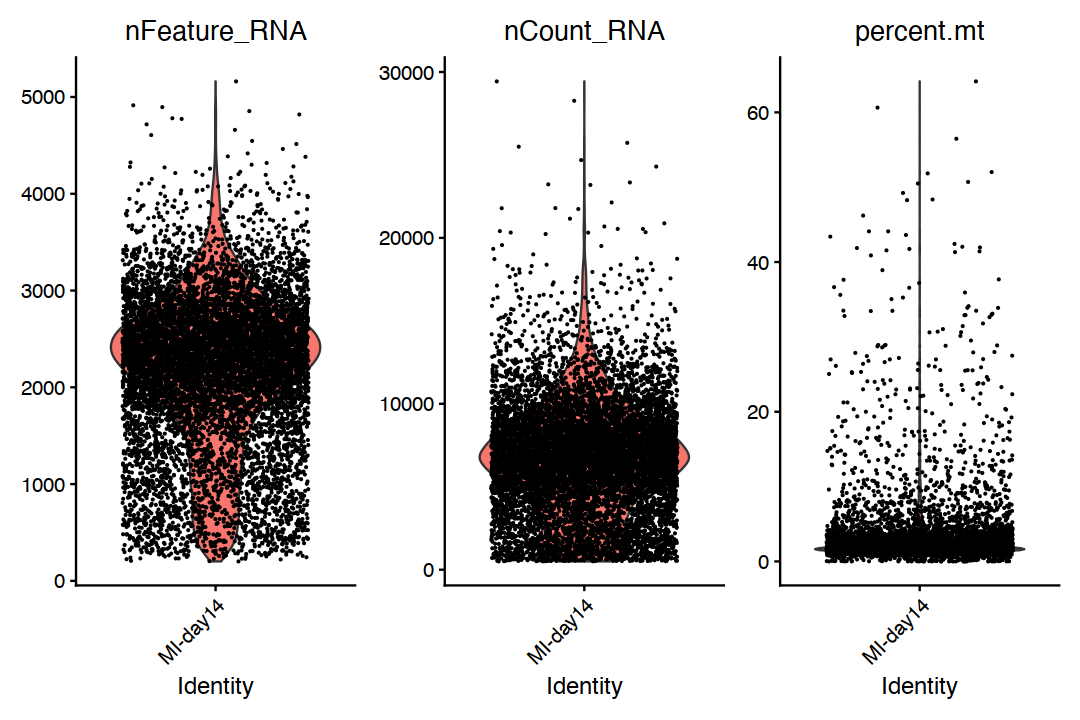

In [4]:
#Violin plot of QC metrics
options(repr.plot.width=9, repr.plot.height=6)
VlnPlot(mid14.seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

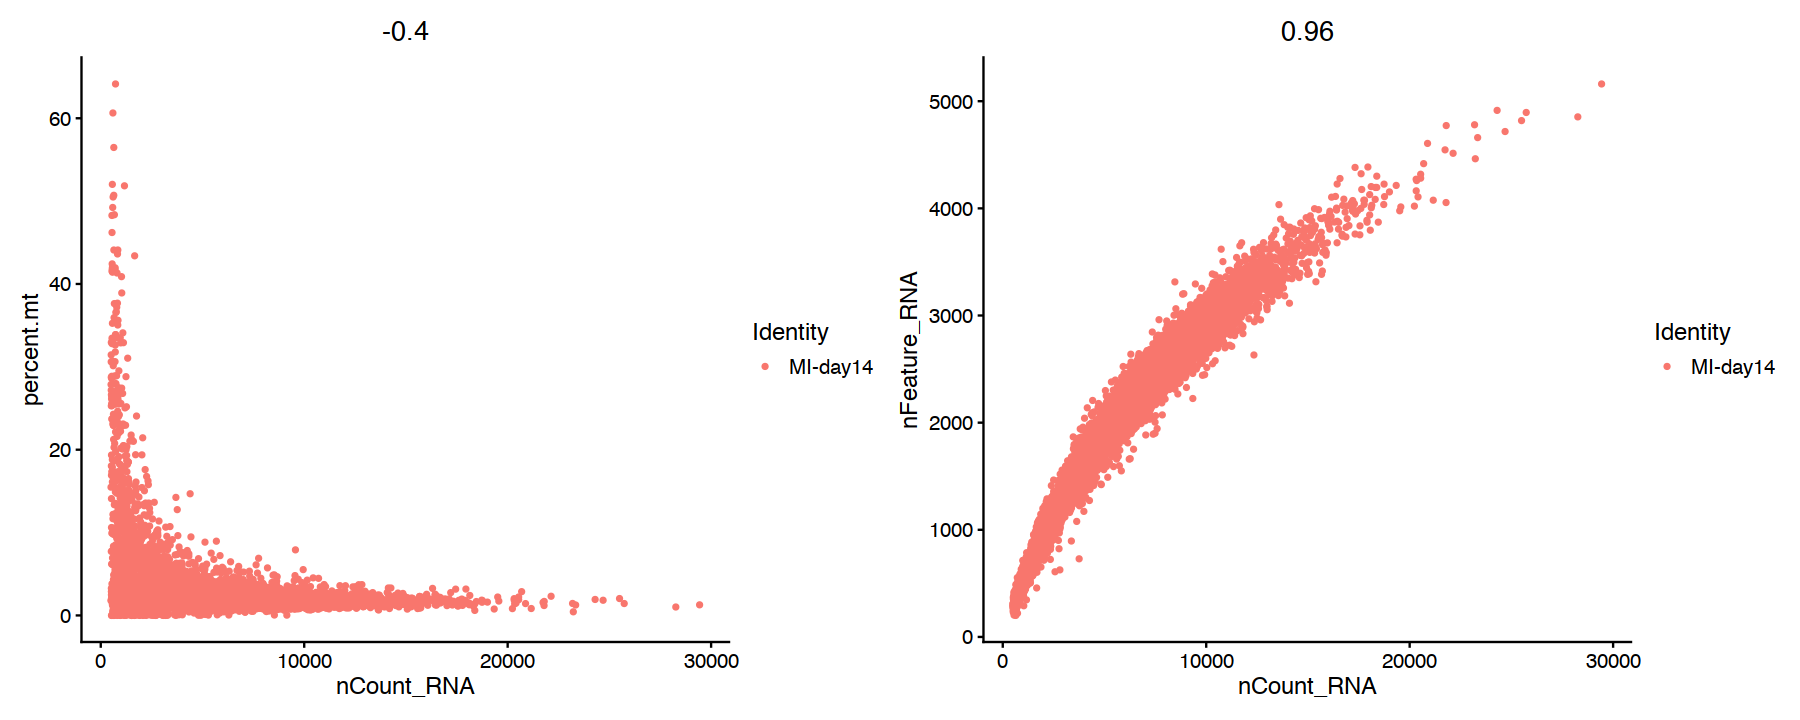

In [7]:
options(repr.plot.width=15, repr.plot.height=6)
plot1 <- FeatureScatter(mid14.seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(mid14.seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [8]:
mid14.seurat <- subset(mid14.seurat, subset = nFeature_RNA > 200 & nFeature_RNA < 4000 & percent.mt < 10 &
                         nCount_RNA > 500 & nCount_RNA < 15000)
dim(mid14.seurat)

# Normalise data
mid14.seurat <- NormalizeData(object = mid14.seurat, 
                              normalization.method = "LogNormalize", 
                              scale.factor = 10000)

# Find higly variable genes
mid14.seurat <- FindVariableFeatures(object = mid14.seurat, mean.function = "vst", nfeatures = 3000)

# Regress of unwanted variation
mid14.seurat <- ScaleData(mid14.seurat, vars.to.regress = c("nCount_RNA"),  verbose = TRUE)

mid14.seurat <- RunPCA(object = mid14.seurat, features = VariableFeatures(object = mid14.seurat), npcs=40)

## Clustering
mid14.seurat <- FindNeighbors(mid14.seurat, dims = 1:25)
mid14.seurat <- FindClusters(mid14.seurat, resolution = c( 0.6, 0.7, 0.8))

### UMAP/t-SNE analysis
mid14.seurat <- RunUMAP(mid14.seurat, dims = 1:25)

Idents(mid14.seurat) <- mid14.seurat@meta.data$RNA_snn_res.0.6

[1] 15242  8712

Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Clec3b, Gsn, Gstm1, Sparcl1, Ms4a4d, Dpep1, Htra3, Pla1a, Gsta3, Tnxb 
	   Slc43a3, Entpd2, Cd34, Ly6a, Smoc2, Abca8a, Ramp2, Ifi27l2a, S100a6, Scara5 
	   Pcsk6, Vwa1, Qpct, Gpx3, Rarres2, Ifitm3, Axl, Tppp3, S100a10, Adamts5 
Negative:  Comp, Cthrc1, Ecrg4, Sfrp2, Ddah1, Fn1, Fmod, Cst3, Ptn, Lox 
	   Cd200, Col1a1, Mdk, Sparc, Pdgfrl, Col1a2, Fxyd6, Postn, Mfap4, Actn1 
	   Tgfb3, Ccn5, Cpxm2, Rflnb, Cpe, Itgbl1, Palld, Col3a1, Ccn2, Lmcd1 
PC_ 2 
Positive:  C1qb, Fcer1g, C1qa, Tyrobp, C1qc, Ctss, Lyz2, Laptm5, Fcgr3, Ms4a7 
	   Cd52, Ctsc, Ly86, Wfdc17, Ucp2, Alox5ap, Cd53, Spi1, Srgn, C5ar1 
	   Lcp1, Aif1, Coro1a, Csf1r, Cd68, Pld4, Cd14, Trem2, Ptpn18, Cd300c2 
Negative:  Bgn, Sparc, Lum, Mfap5, Serpinf1, Loxl1, Fstl1, Gsn, Col3a1, Col1a2 
	   Ccdc80, Pcolce, Rbp1, Mmp2, Fbln1, Islr, Mfap4, Pi16, Htra3, Cfh 
	   Ogn, Mgp, Prelp, Igfbp4, Pcolce2, Fxyd6, Col1a1, Cygb, Col8a1, Cd34 
PC_ 3 
Positive:  Rg

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8712
Number of edges: 282009

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8091
Number of communities: 12
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8712
Number of edges: 282009

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7960
Number of communities: 14
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8712
Number of edges: 282009

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7836
Number of communities: 15
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
12:51:54 UMAP embedding parameters a = 0.9922 b = 1.112

12:51:54 Read 8712 rows and found 25 numeric columns

12:51:54 Using Annoy for neighbor search, n_neighbors = 30

12:51:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:51:55 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//Rtmp8B5f81/file5174472d8ece

12:51:55 Searching Annoy index using 1 thread, search_k = 3000

12:51:57 Annoy recall = 100%

12:51:57 Commencing smooth kNN distance calibrat

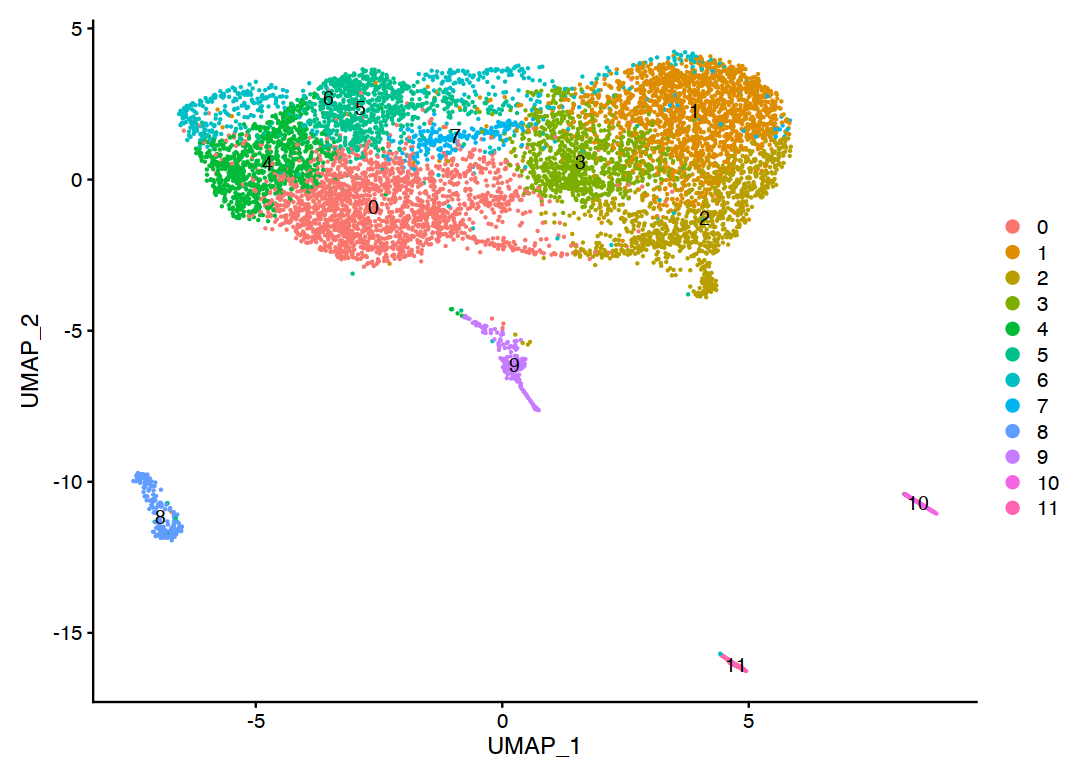

In [11]:
options(repr.plot.width=9, repr.plot.height=6.5)
DimPlot(mid14.seurat, reduction = "umap", label = TRUE)

# Doublet filtering

Visualise and filter doublets identified with Scrublet

[1] "Predicted singlets from Scrublet: 9125"
[1] "Overlap with filtered data: 8640"


[1] 8640

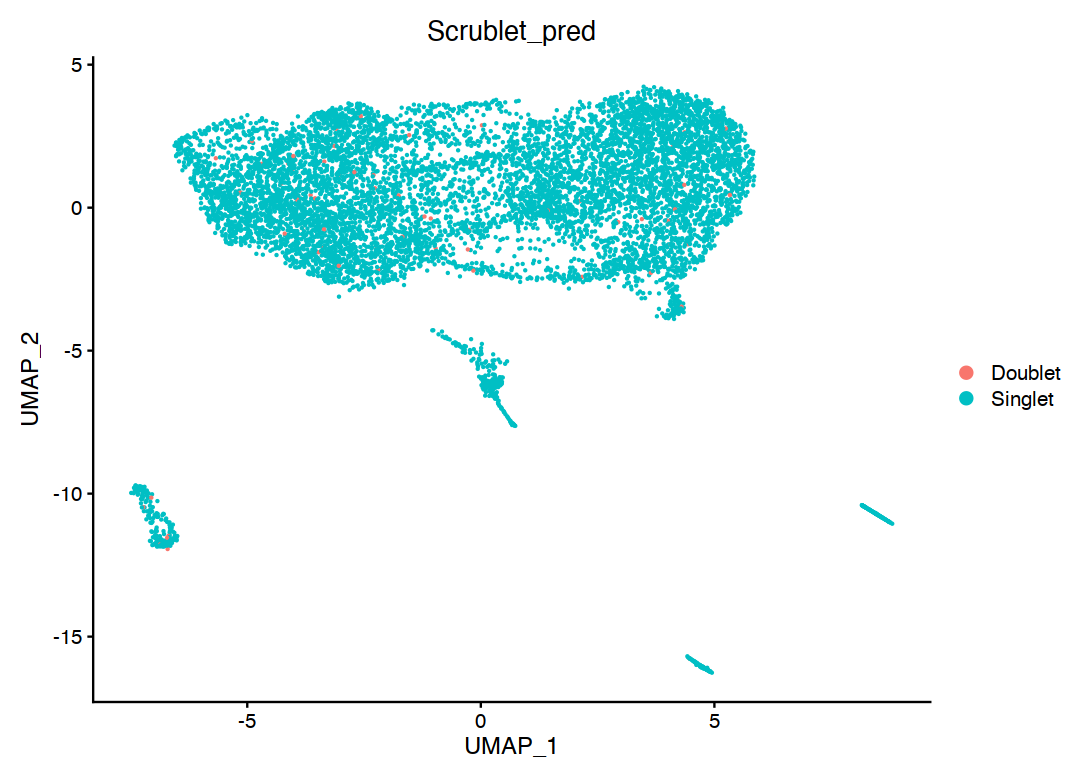

In [13]:
singlet.file <- "Scrublet/MI_day14_singlets.txt"

all.singlets <- readLines(singlet.file)

print(paste("Predicted singlets from Scrublet:", length(all.singlets)))
print(paste("Overlap with filtered data:", length(intersect(colnames(mid14.seurat), all.singlets))))
length(intersect(colnames(mid14.seurat), all.singlets))

scrublet.doublet <- ifelse(colnames(mid14.seurat) %in% all.singlets, "Singlet", "Doublet")
mid14.seurat@meta.data$Scrublet_pred <- scrublet.doublet

options(repr.plot.width=9, repr.plot.height=6.5)
DimPlot(mid14.seurat, group.by = "Scrublet_pred")

In [21]:
# Filter the Seurat object for singlets and re-run clustering analysis
mid14.seurat <- subset(mid14.seurat, Scrublet_pred == "Singlet")
dim(mid14.seurat)

# Normalise data
mid14.seurat <- NormalizeData(object = mid14.seurat, 
                              normalization.method = "LogNormalize", 
                              scale.factor = 10000)

# Find higly variable genes
mid14.seurat <- FindVariableFeatures(object = mid14.seurat, mean.function = "vst", nfeatures = 3000)

# Regress of unwanted variation
mid14.seurat <- ScaleData(mid14.seurat,  vars.to.regress = c("nCount_RNA"),  verbose = TRUE)

mid14.seurat <- RunPCA(object = mid14.seurat, features = VariableFeatures(object = mid14.seurat), npcs=60)

## Clustering
mid14.seurat <- FindNeighbors(mid14.seurat,  dims = 1:25)
mid14.seurat <- FindClusters(mid14.seurat, resolution = seq(0.4, 1))

### UMAP/t-SNE analysis
mid14.seurat <- RunUMAP(mid14.seurat, dims = 1:25)

[1] 15242  8640

Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Clec3b, Gsn, Gstm1, Sparcl1, Ms4a4d, Dpep1, Htra3, Pla1a, Gsta3, Tnxb 
	   Slc43a3, Entpd2, Cd34, Ly6a, Smoc2, Abca8a, Ramp2, Ifi27l2a, Pcsk6, Scara5 
	   S100a6, Vwa1, Qpct, Gpx3, Rarres2, Ifitm3, Axl, Tppp3, S100a10, Adamts5 
Negative:  Comp, Cthrc1, Ecrg4, Sfrp2, Ddah1, Fn1, Fmod, Cst3, Ptn, Lox 
	   Cd200, Col1a1, Mdk, Sparc, Pdgfrl, Col1a2, Fxyd6, Postn, Mfap4, Actn1 
	   Tgfb3, Ccn5, Rflnb, Cpxm2, Cpe, Itgbl1, Palld, Col3a1, Ccn2, Lmcd1 
PC_ 2 
Positive:  C1qb, Fcer1g, C1qa, Tyrobp, C1qc, Ctss, Lyz2, Laptm5, Fcgr3, Ms4a7 
	   Cd52, Ctsc, Ly86, Wfdc17, Ucp2, Cd53, Alox5ap, Spi1, Srgn, C5ar1 
	   Lcp1, Aif1, Coro1a, Csf1r, Cd68, Pld4, Cd14, Trem2, Ptpn18, Cd300c2 
Negative:  Bgn, Sparc, Lum, Mfap5, Serpinf1, Loxl1, Fstl1, Col3a1, Gsn, Col1a2 
	   Ccdc80, Rbp1, Pcolce, Mmp2, Fbln1, Mfap4, Islr, Pi16, Htra3, Cfh 
	   Mgp, Ogn, Prelp, Igfbp4, Col1a1, Fxyd6, Pcolce2, Col8a1, Cygb, Cd34 
PC_ 3 
Positive:  Rg

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8640
Number of edges: 280871

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8401
Number of communities: 11
Elapsed time: 0 seconds


14:38:19 UMAP embedding parameters a = 0.9922 b = 1.112

14:38:19 Read 8640 rows and found 25 numeric columns

14:38:19 Using Annoy for neighbor search, n_neighbors = 30

14:38:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:38:19 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//Rtmp8B5f81/file517458f4da56

14:38:19 Searching Annoy index using 1 thread, search_k = 3000

14:38:21 Annoy recall = 100%

14:38:21 Commencing smooth kNN distance calibration using 1 thread

14:38:21 Initializing from normalized Laplacian + noise

14:38:22 Commencing optimization for 500 epochs, with 365208 positive edges

14:38:32 Optimization finished



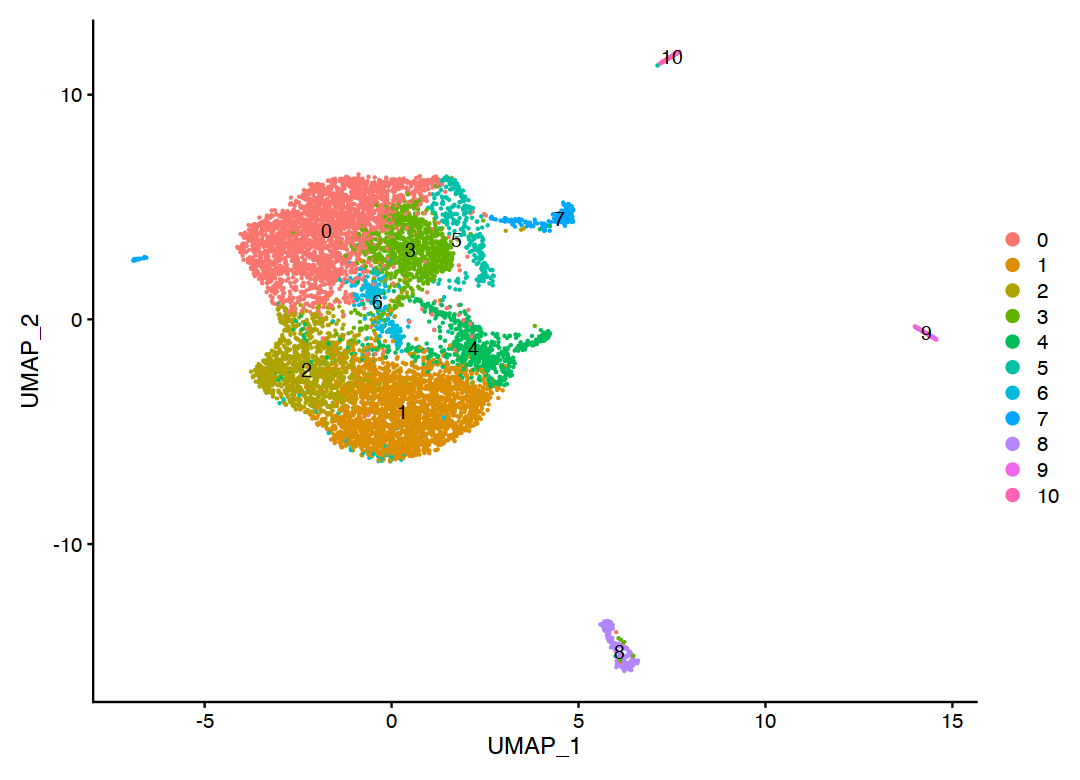

In [22]:
options(repr.plot.width=9, repr.plot.height=6.5)
Idents(mid14.seurat) <- mid14.seurat@meta.data$RNA_snn_res.0.4

DimPlot(mid14.seurat, reduction = "umap", label = TRUE)

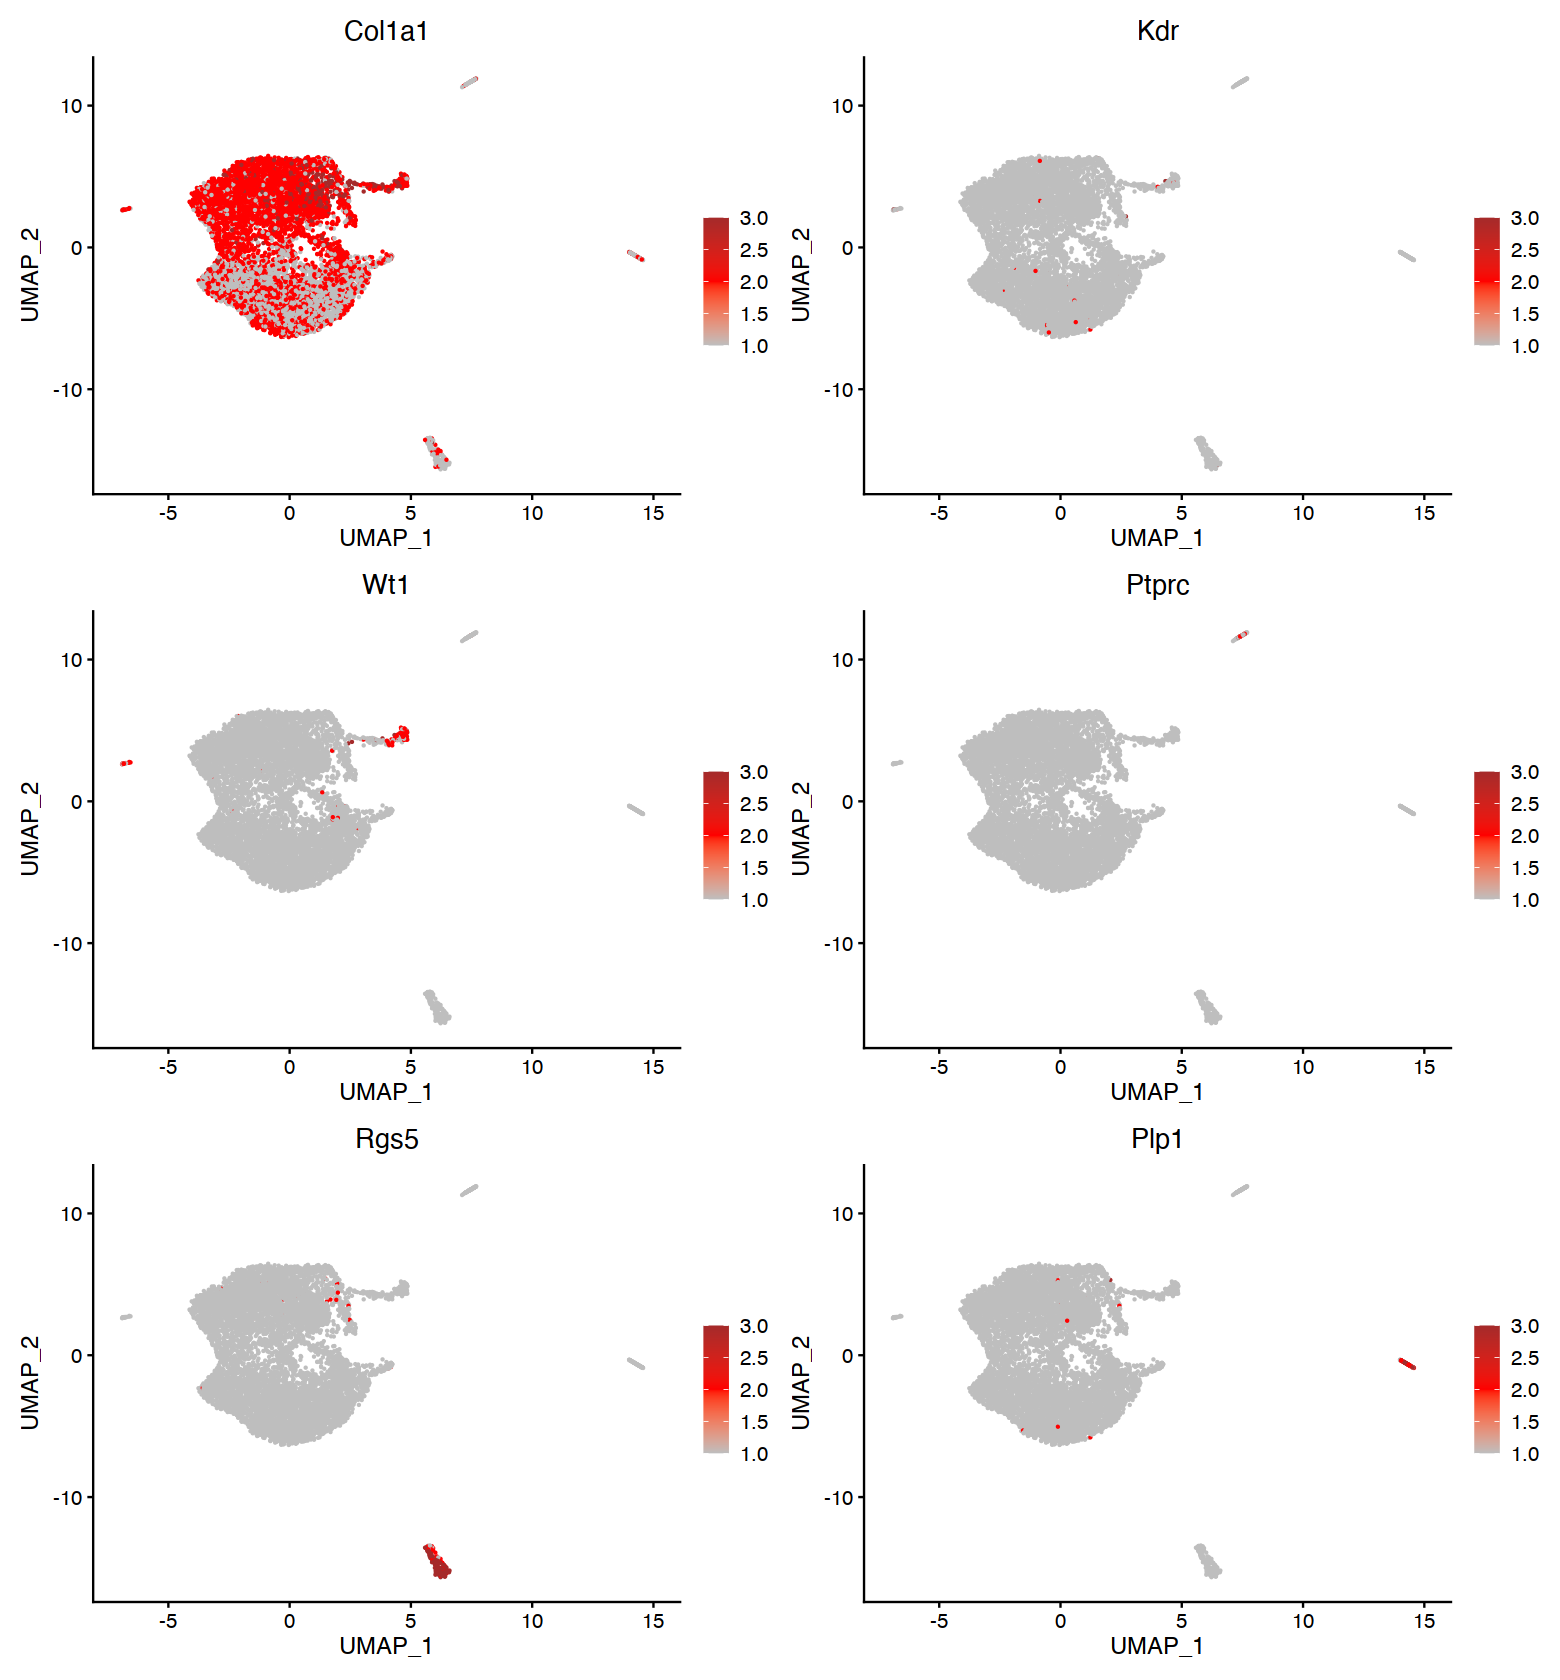

In [28]:
options(repr.plot.width=13, repr.plot.height=14)
FeaturePlot(mid14.seurat, c("Col1a1", "Kdr", "Wt1", "Ptprc", "Rgs5", "Plp1"), 
            cols = c("grey", "red", "brown"))

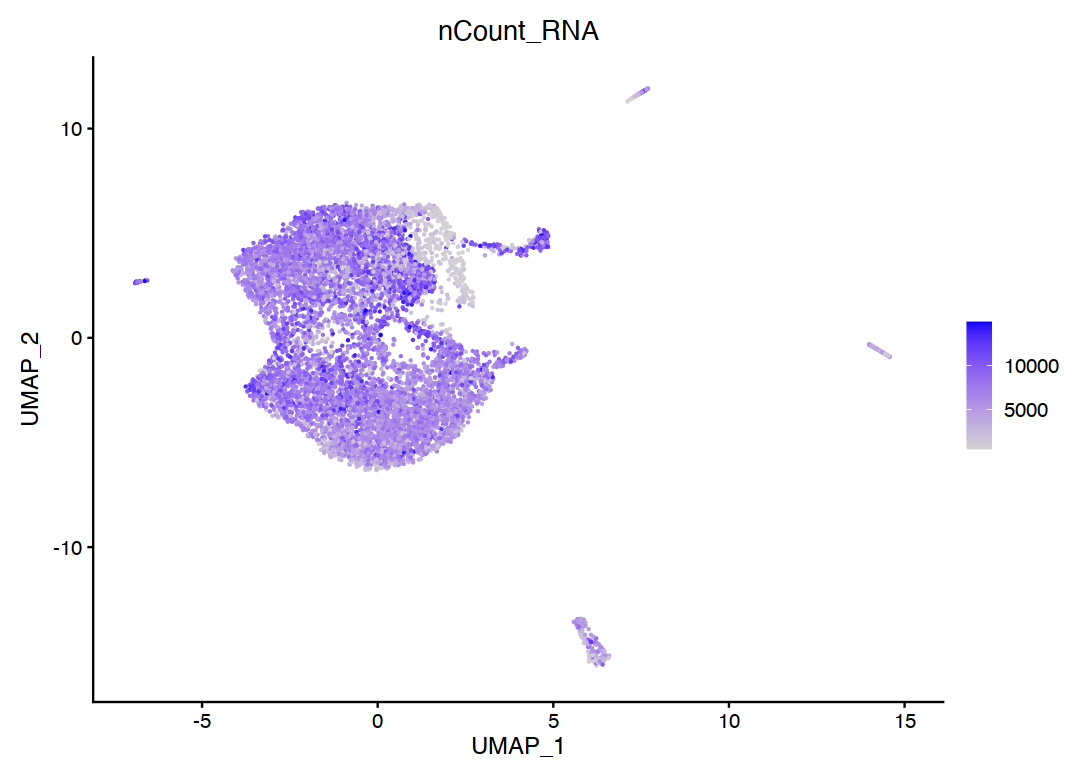

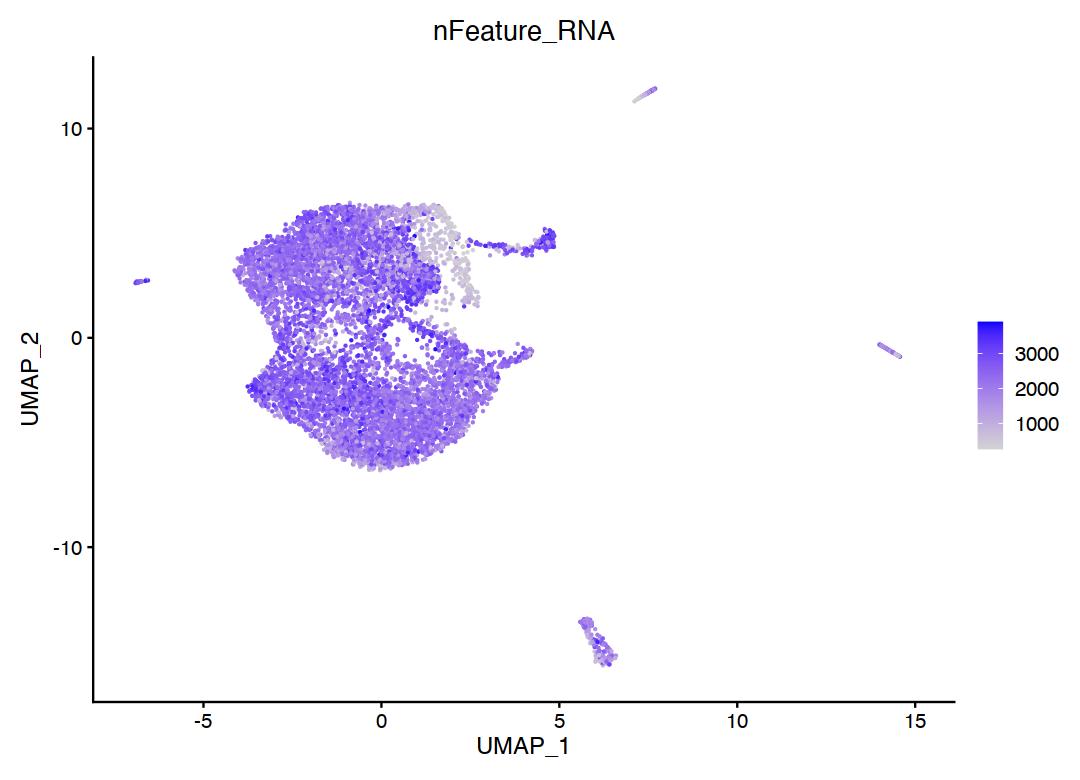

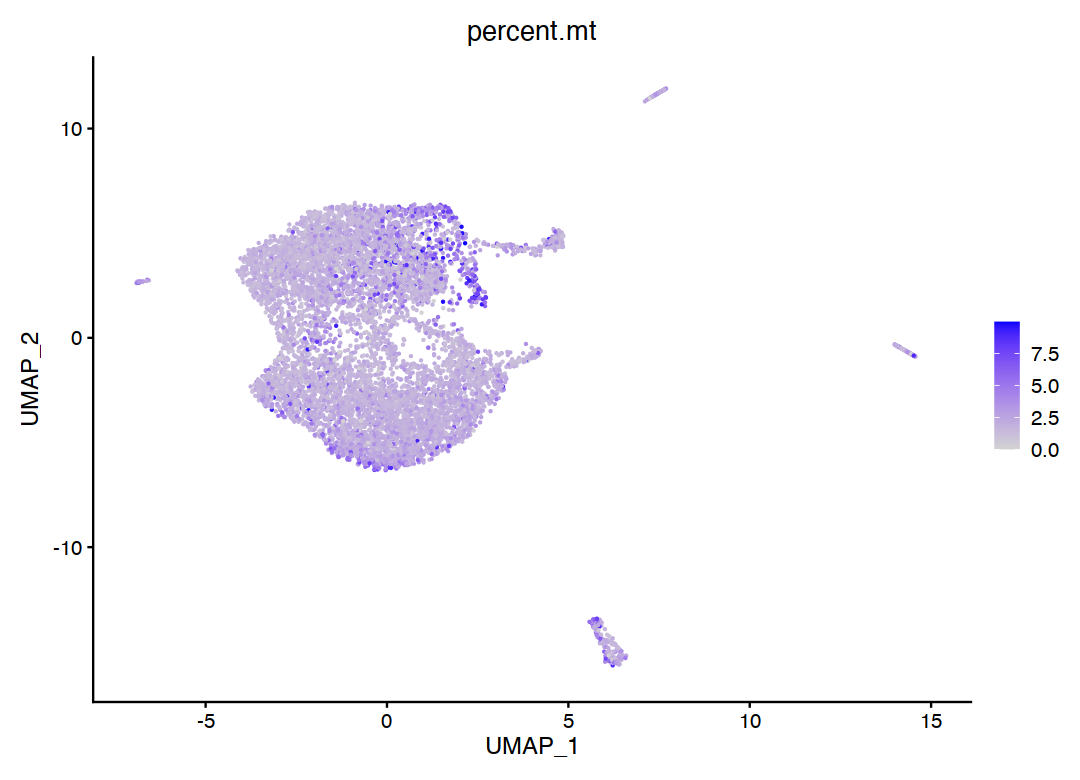

In [29]:
options(repr.plot.width=9, repr.plot.height=6.5)

FeaturePlot(mid14.seurat, "nCount_RNA")
FeaturePlot(mid14.seurat, "nFeature_RNA")
FeaturePlot(mid14.seurat, "percent.mt")

High confidence fibroblast clusters are 0, 1, 2, 3, 4 and 6. 

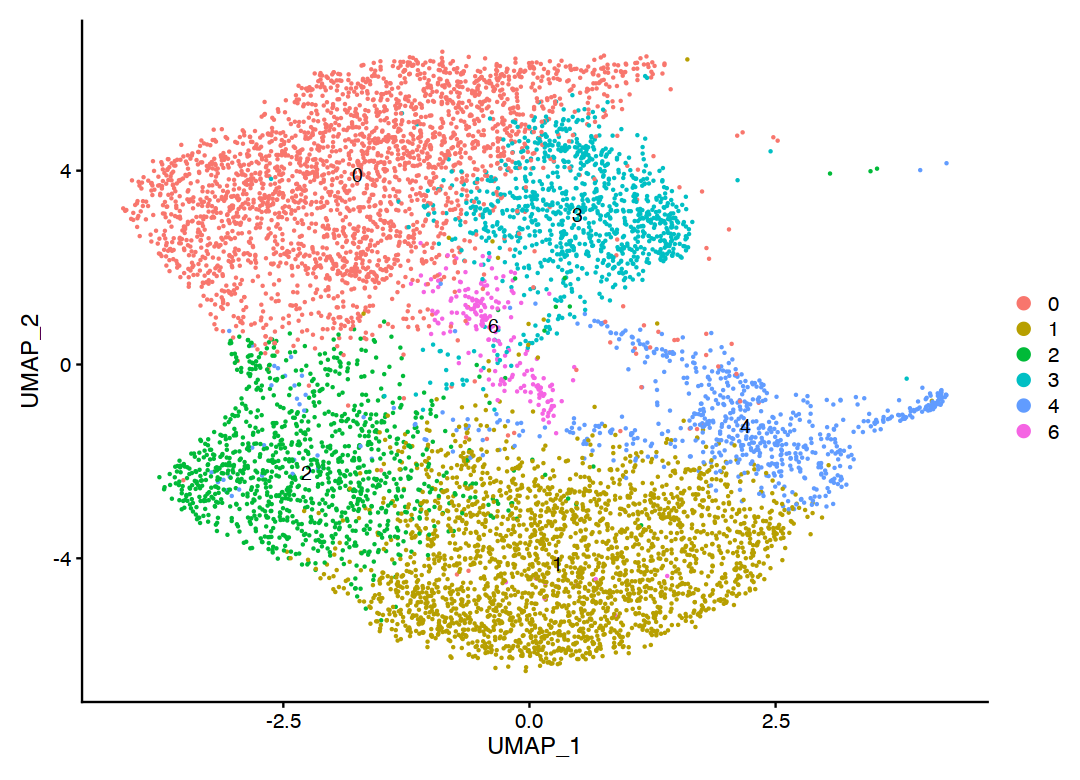

In [31]:
### Sub-select fibroblasts for subsequent downstream analysis

fibro.clusters <- c("0", "1", "2", "3", "4", "6")

mid14.fibroblasts <- subset(mid14.seurat, idents = fibro.clusters)

mid14.fibroblasts <- subset(mid14.fibroblasts, UMAP_1 < 5)
mid14.fibroblasts <- subset(mid14.fibroblasts, UMAP_2 < 8 & UMAP_2 > -8)

options(repr.plot.width=9, repr.plot.height=6.5)
DimPlot(mid14.fibroblasts, label = TRUE)


# Recluster subsetted fibroblasts

In [33]:
### Run reclustering based on selected fibroblasts 

mid14.fibroblasts <- FindVariableFeatures(object = mid14.fibroblasts, mean.function = "vst", nfeatures = 2000)

# Regress of unwanted variation
mid14.fibroblasts <- ScaleData(mid14.fibroblasts,  vars.to.regress = c("nCount_RNA"),  verbose = TRUE)

mid14.fibroblasts <- RunPCA(object = mid14.fibroblasts, features = VariableFeatures(object = mid14.fibroblasts), npcs=50)

## Clustering
mid14.fibroblasts <- FindNeighbors(mid14.fibroblasts, k.param = 50, dims = 1:50)
mid14.fibroblasts <- FindClusters(mid14.fibroblasts, resolution = c(0.7, 0.8, 0.9, 1, 1.2))

Idents(mid14.fibroblasts) <- mid14.fibroblasts@meta.data$RNA_snn_res.0.9


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Gsn, Clec3b, Gstm1, Sparcl1, Ms4a4d, Htra3, Dpep1, Pla1a, Tnxb, Gsta3 
	   Cd34, Slc43a3, Ly6a, S100a6, Smoc2, Ramp2, Abca8a, Ifi27l2a, Vwa1, Scara5 
	   Pcsk6, Rarres2, Tppp3, Gpx3, S100a10, Axl, Ifitm3, Qpct, Adamts5, Dpt 
Negative:  Comp, Cthrc1, Ecrg4, Sfrp2, Cst3, Ddah1, Sparc, Fn1, Col1a1, Col1a2 
	   Fmod, Fxyd6, Ptn, Mfap4, Lox, Cd200, Pdgfrl, Mdk, Postn, Col3a1 
	   Ccn5, Itgbl1, Tgfb3, Actn1, Rflnb, Cpxm2, Fbln5, Cpe, Frzb, Ccn2 
PC_ 2 
Positive:  Mfap5, Crip1, Postn, Fstl1, Pi16, Cd248, Cd9, Igfbp6, Cavin3, Fibin 
	   Nbl1, Ckb, Aspn, Fbn1, Efhd1, Thbs4, Cilp, Crlf1, Tmsb4x, S100a10 
	   Fxyd5, Anxa2, S100a6, Vcan, Fbln2, Lgals1, Cst6, Stmn4, Sema3c, Ltbp2 
Negative:  Apoe, Junb, Mt1, Zfp36, Socs3, Cebpd, Selenop, Fbln1, Egr1, Fgl2 
	   Cxcl1, Cpxm1, C1ra, Fos, Btg2, Gpx3, Vcam1, Dpep1, Mt2, Tmem176b 
	   Mgst1, Il11ra1, Srpx, Irf1, Gadd45g, Jun, C1s1, Ccl19, Fosb, Gpm6b 
PC_ 3 
Positive:  Hsd11b

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7764
Number of edges: 731157

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7296
Number of communities: 9
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7764
Number of edges: 731157

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7116
Number of communities: 8
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7764
Number of edges: 731157

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6957
Number of communities: 9
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7764
Number of edges: 731157

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6804
Number of communities: 9
Elapsed time: 2 seconds
Modularity Optimizer

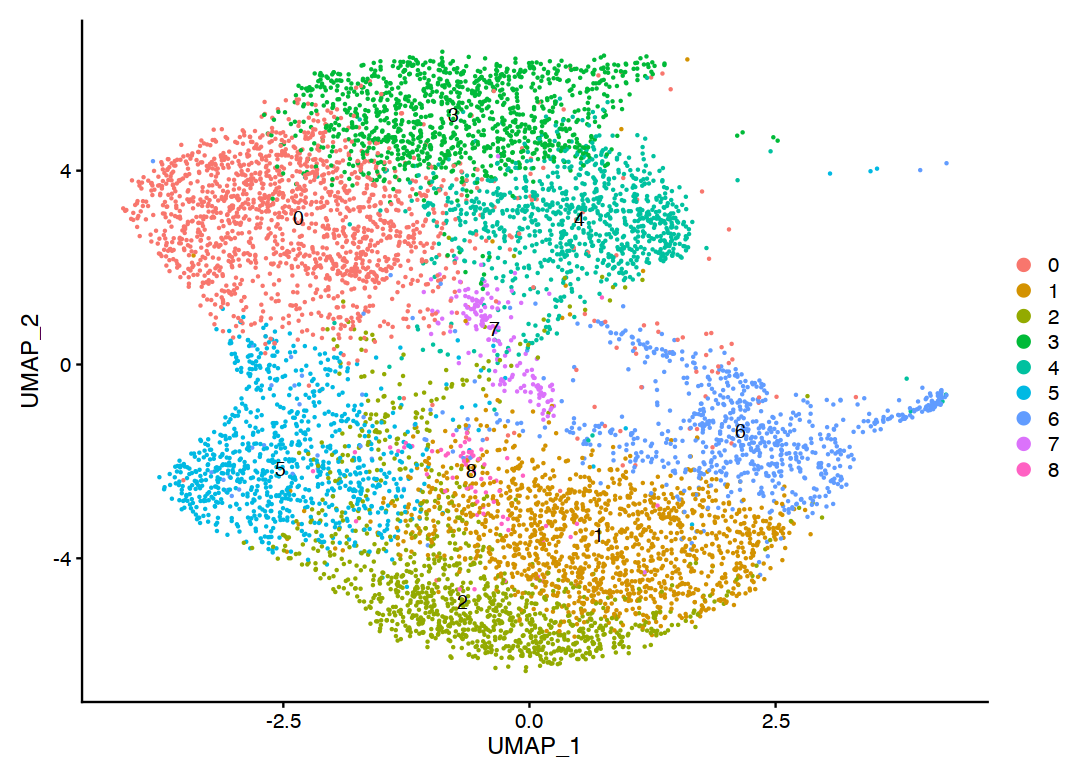

In [34]:
options(repr.plot.width=9, repr.plot.height=6.5)
DimPlot(mid14.fibroblasts, reduction = "umap", label = TRUE)

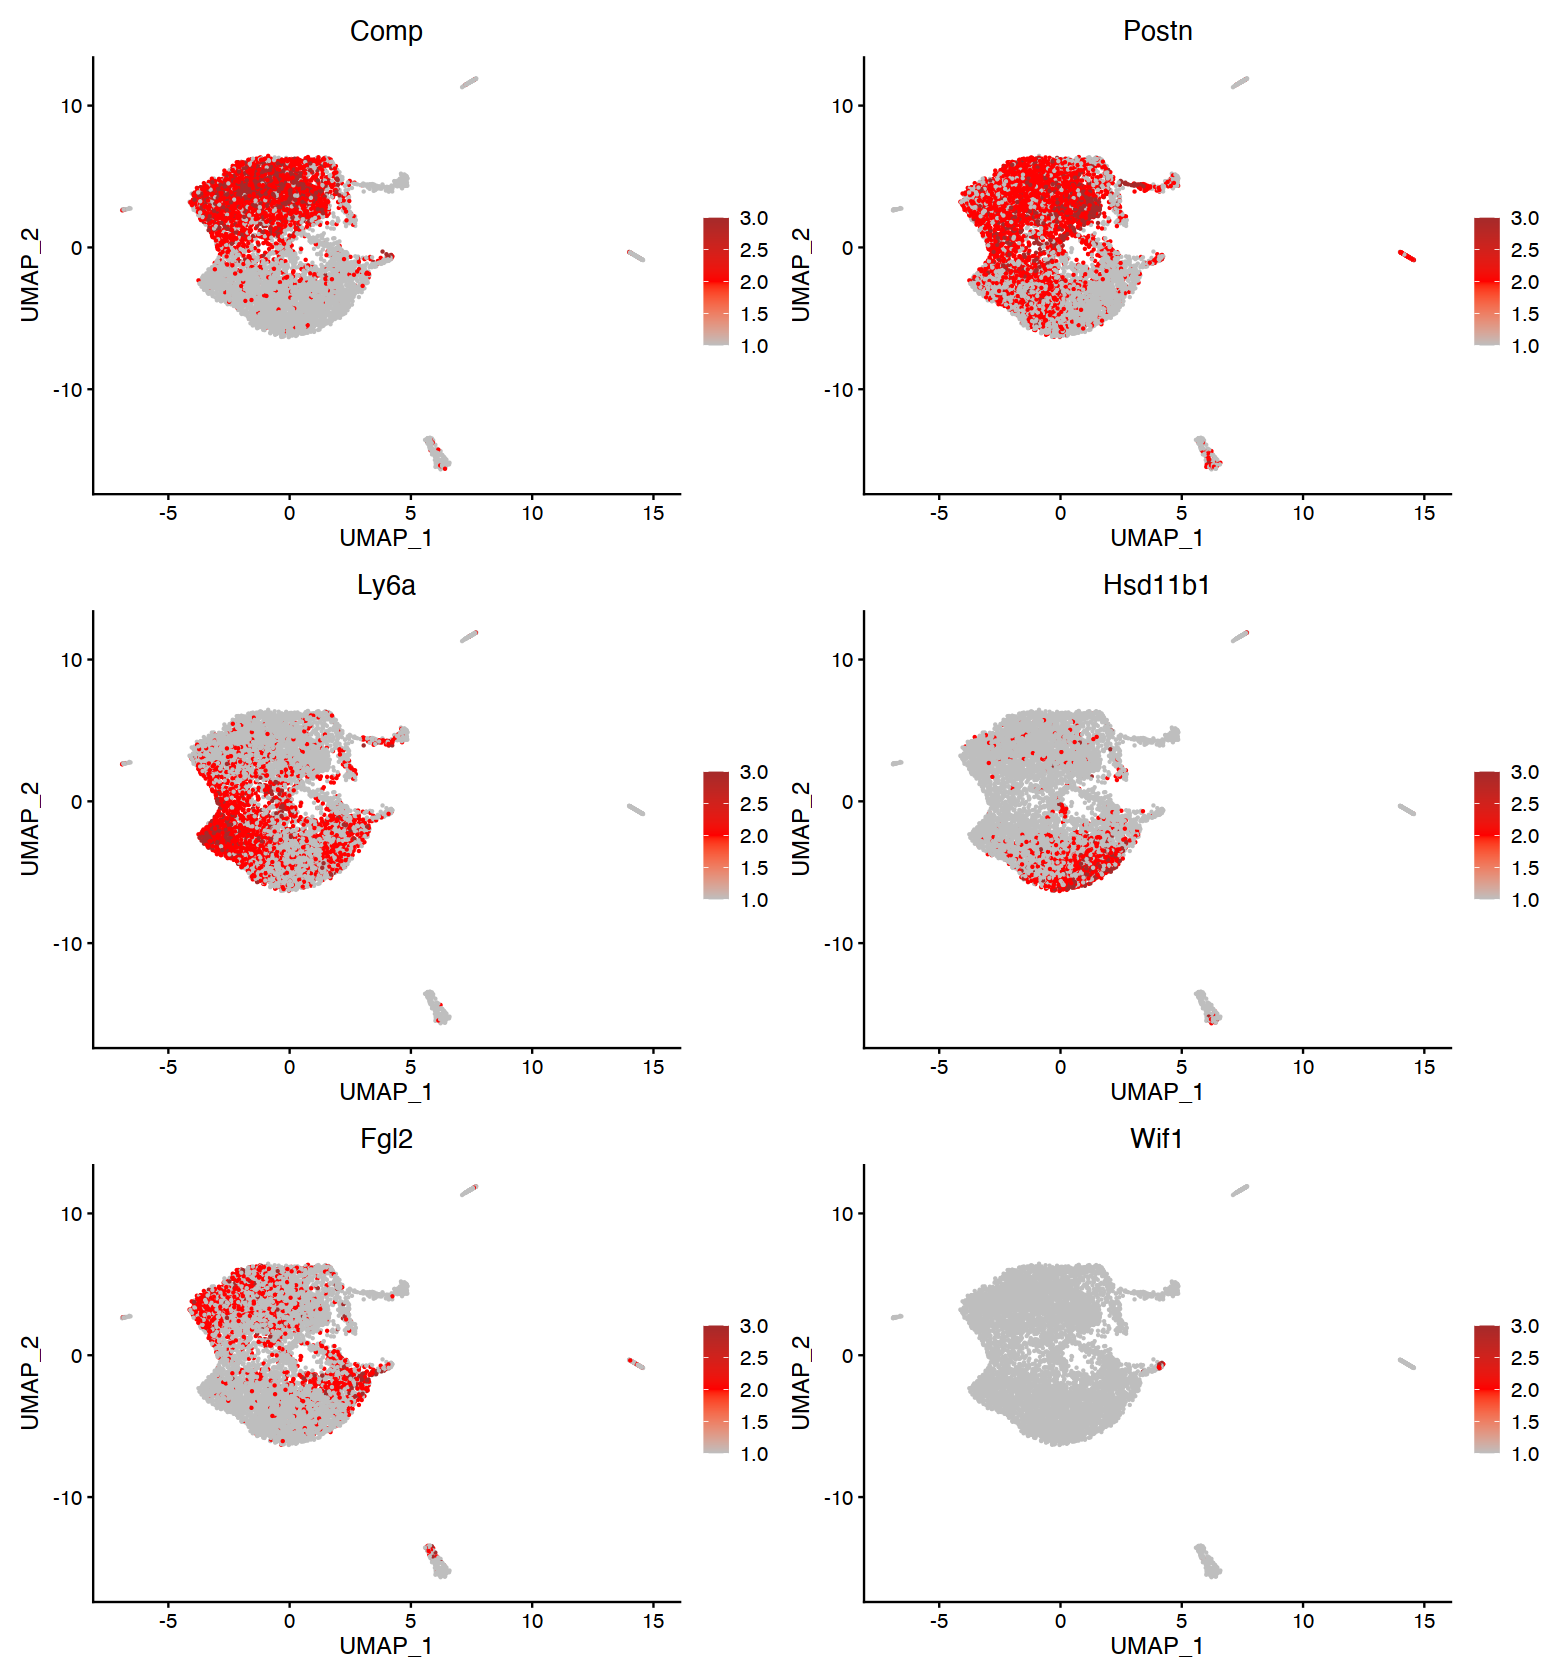

In [35]:
options(repr.plot.width=13, repr.plot.height=14)
FeaturePlot(mid14.seurat, c("Comp", "Postn", "Ly6a", "Hsd11b1", "Fgl2", "Wif1"), 
            cols = c("grey", "red", "brown"))

# Label transfer analysis

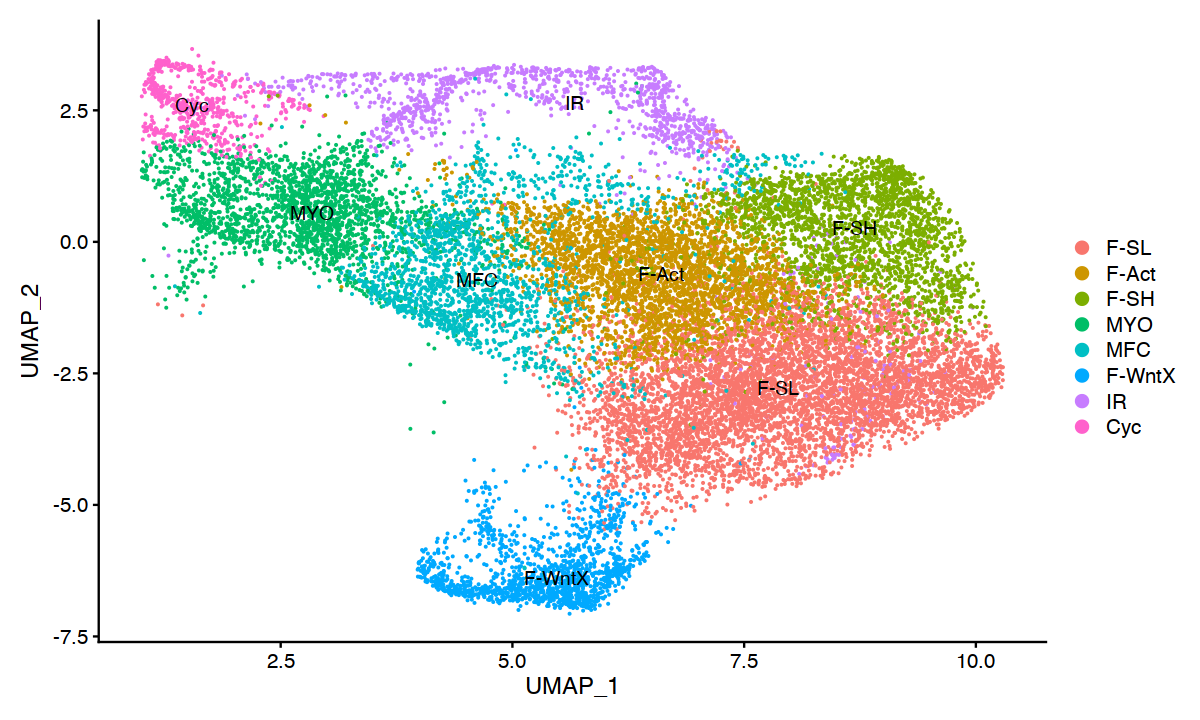

In [38]:
### Try using the Forte et al. MI time course data for transfer analysis 

load("../Forte/fibroblasts_Forte_MI_timecourse.RData")
forte.fibroblasts <- fibroblasts.seurat
remove(fibroblasts.seurat)

options(repr.plot.width=10, repr.plot.height=6)
DimPlot(forte.fibroblasts, label = TRUE)  


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Gsn, Clec3b, Dpep1, Jund, Junb, Smoc2, Cebpd, Sparcl1, Klf4, Adamts5 
	   Fth1, Jun, Scara5, Cfh, Lpl, Pcsk6, Dusp1, Glul, Fos, Egr1 
	   Ly6a, Selenbp1, Pi16, Ifi205, G0s2, Tsc22d3, Klf2, Igfbp6, Socs3, Zfp36 
Negative:  Cthrc1, Acta2, Postn, Tagln, Stmn1, Csrp2, Ddah1, Fn1, Lgals1, Cks2 
	   Pclaf, Birc5, Col1a1, Tpm2, Cdca3, Cdca8, Lox, Spc24, Cenpa, Tpx2 
	   Actb, Cdk1, Cdc20, Ccna2, Ube2c, Ccnb2, Cenpm, Ccn4, Sparc, Tk1 
PC_ 2 
Positive:  Birc5, Pclaf, Cdca8, Ccna2, Cks2, Cdca3, Cdc20, Tpx2, Ube2c, Top2a 
	   Prc1, Pbk, Stmn1, Ccnb1, Cenpa, Spc24, Ccnb2, Cenpm, Pimreg, Tk1 
	   Spc25, Racgap1, Mki67, Tubb6, Cenpf, Cdkn3, Knstrn, Cdk1, Hmmr, Ckap2l 
Negative:  Comp, Ecrg4, Mfap4, Cst3, Fmod, Dkk3, Fxyd6, Ltbp2, Sfrp2, Ddah1 
	   Col8a2, Col1a2, Postn, Itgbl1, Cd200, Igfbp7, Pdgfrl, Cilp, Tgfb3, Rflnb 
	   Cpe, Mgp, Col1a1, Pdlim3, Timp3, Fn1, Cthrc1, Col5a2, Ccn5, Mdk 
PC_ 3 
Positive:  Mfap5, Pi16, Fs

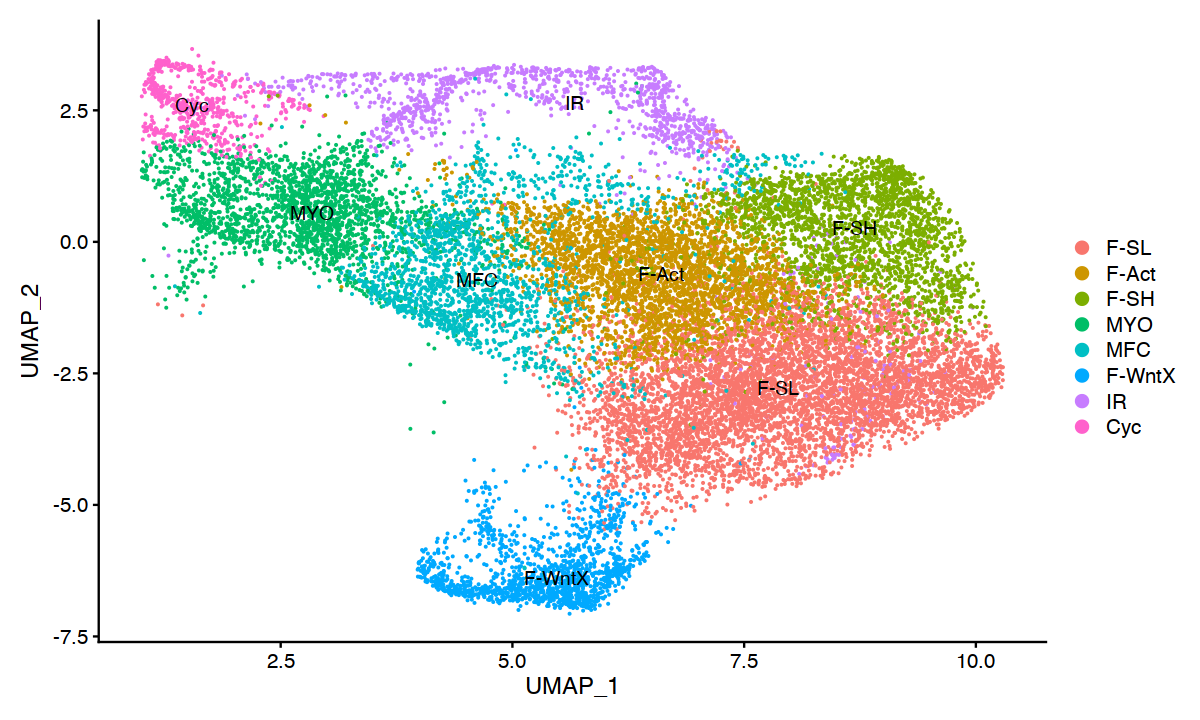

In [39]:
forte.fibroblasts <- FindVariableFeatures(object = forte.fibroblasts, 
                                          mean.function = "vst", 
                                          nfeatures = 2000)

forte.fibroblasts <- ScaleData(forte.fibroblasts, 
                               vars.to.regress = "nCount_RNA", 
                               verbose = TRUE)

forte.fibroblasts <- RunPCA(object = forte.fibroblasts, 
                            features = VariableFeatures(object = forte.fibroblasts), npcs=60)

DimPlot(forte.fibroblasts, reduction = 'umap', label = TRUE)

fibro.anchors <- FindTransferAnchors(reference = forte.fibroblasts, 
                                     query = mid14.fibroblasts, 
                                     dims = 1:30)
predictions <- TransferData(anchorset = fibro.anchors, 
                            refdata = Idents(forte.fibroblasts), 
                            dims = 1:30)
colnames(predictions) <- paste0("Forte_", colnames(predictions))
mid14.fibroblasts <- AddMetaData(mid14.fibroblasts, metadata = predictions)

Idents(mid14.fibroblasts) <- mid14.fibroblasts$Forte_predicted.id

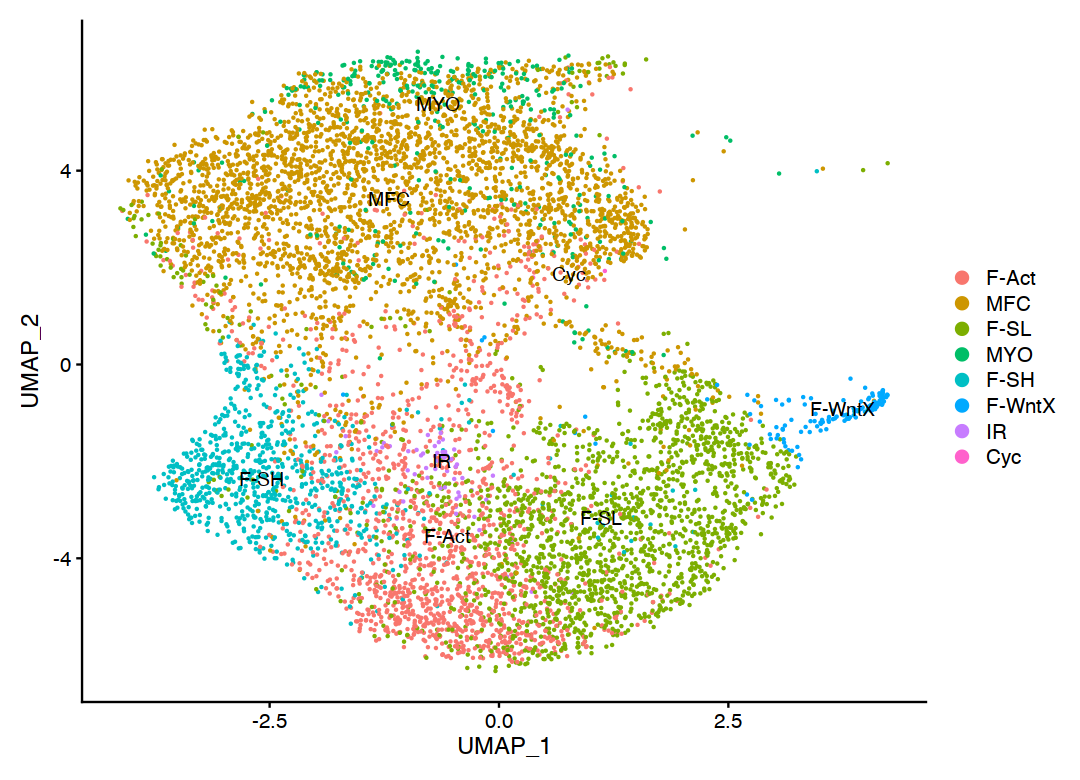

In [42]:
options(repr.plot.width=9, repr.plot.height=6.5)
DimPlot(mid14.fibroblasts, reduction = 'umap', label = TRUE)

In [46]:

Idents(mid14.fibroblasts) <- mid14.fibroblasts@meta.data$RNA_snn_res.0.9
marker.table <- FindMarkers(mid14.fibroblasts, ident.1 = "7")
head(marker.table, n = 20)


p_val         avg_log2FC pct.1 pct.2 p_val_adj    
Rsad2   0.000000e+00 2.6199285  0.500 0.011  0.000000e+00
Ifit3b  0.000000e+00 2.3313237  0.810 0.048  0.000000e+00
Ifi44  3.340704e-273 1.0796948  0.399 0.011 5.091902e-269
Ifit1  8.883953e-253 3.4032106  0.905 0.097 1.354092e-248
Oasl1  1.291077e-229 0.6574881  0.253 0.004 1.967860e-225
Gm4951 7.365693e-201 1.5616920  0.658 0.057 1.122679e-196
Iigp1  1.416121e-197 3.0028145  0.848 0.109 2.158451e-193
Usp18  1.065520e-193 2.2948315  0.804 0.100 1.624066e-189
Ifi47  5.835426e-193 1.7913115  0.595 0.047 8.894357e-189
Ifit3  4.589280e-186 4.3640510  0.962 0.184 6.994981e-182
Gbp6   6.332211e-186 1.0264864  0.525 0.037 9.651557e-182
Igtp   3.611109e-181 2.2642531  0.753 0.091 5.504053e-177
Cmpk2  1.896638e-162 1.4284928  0.468 0.034 2.890855e-158
Isg15  3.123143e-162 3.8820530  0.987 0.233 4.760294e-158
Irf7   4.523011e-144 2.0757588  0.848 0.156 6.893974e-140
Oasl2  2.671624e-143 1.8357563  0.867 0.166 4.072089e-139
Gbp3   3.195311e-142 1.5231327  0.722 0.103 4.870293e-138
Rtp4   1.861227e-141 2.1434263  0.918 0.196 2.836882e-137
Oas1a  5.384625e-140 1.0052852  0.456 0.037 8.207245e-136
Zbp1   5.826256e-140 1.1602790  0.500 0.046 8.880379e-136

Cluster 7 upregulated markers of the IFN responsive fibroblasts (F-IFNS).

Putting it together, clusters 0, 3 and 4 are matrifibrocytes (MFC), cluster 1 = F-SL, cluster 2 = F-Act, cluster 5 = F-SH, cluster 6 = F-Trans, cluster 7 = F-IFNS and cluster 8 = IR

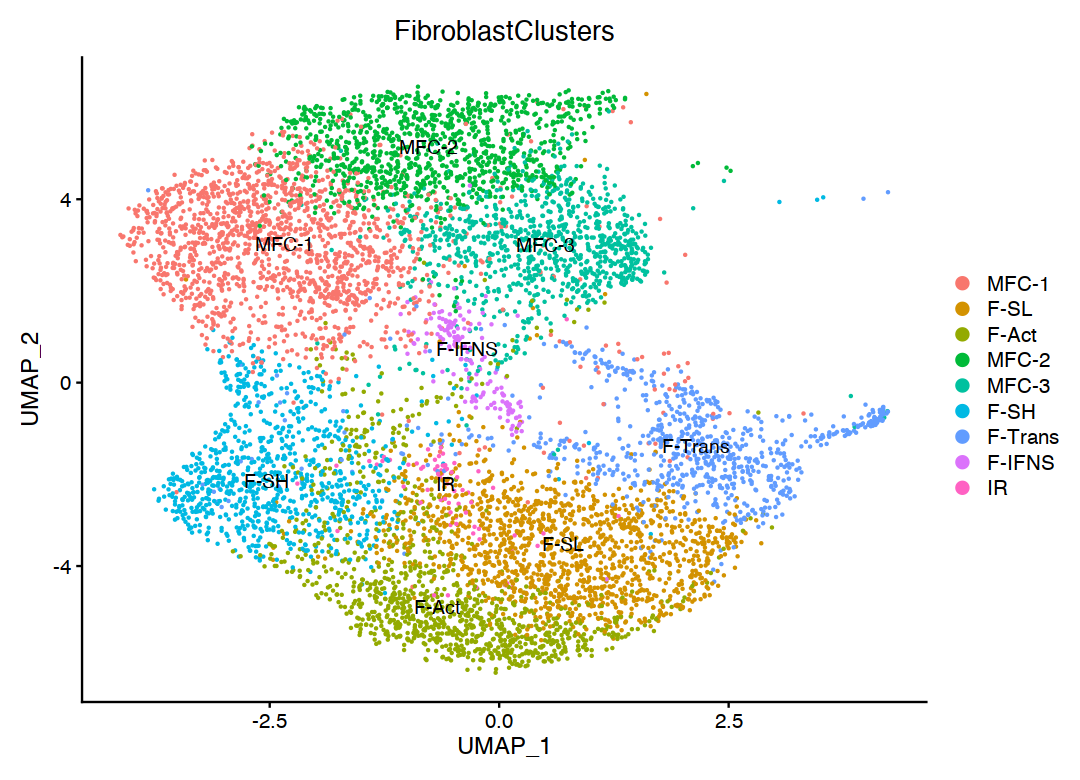

In [44]:

Idents(mid14.fibroblasts) <- mid14.fibroblasts@meta.data$RNA_snn_res.0.9
Idents(mid14.fibroblasts) <- plyr::mapvalues(Idents(mid14.fibroblasts), 
                                             from = c("0", "1", "2", "3", "4", "5", "6", "7", "8"),
                                             to = c("MFC-1", "F-SL", "F-Act", "MFC-2", "MFC-3", "F-SH",
                                                    "F-Trans", "F-IFNS", "IR"))
mid14.fibroblasts$FibroblastClusters <- Idents(mid14.fibroblasts)

options(repr.plot.width=9, repr.plot.height=6.5)
DimPlot(mid14.fibroblasts, label = TRUE, group.by = "FibroblastClusters")


# Session information

In [47]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] en_AU.UTF-8/en_AU.UTF-8/en_AU.UTF-8/C/en_AU.UTF-8/en_AU.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] Matrix_1.3-4       dplyr_1.0.7        plyr_1.8.6         SeuratObject_4.0.2
[5] Seurat_4.0.3       ggplot2_3.3.5     

loaded via a namespace (and not attached):
  [1] nlme_3.1-152          spatstat.sparse_2.0-0 matrixStats_0.60.0   
  [4] RcppAnnoy_0.0.19      RColorBrewer_1.1-2    httr_1.4.2           
  [7] repr_1.1.3            sctransform_0.3.2     tools_4.1.0          
 [10] utf8_1.2.2            R6_2.5.0              irlba_2.3.3          
 [13] rpart_4.1-15          KernSmooth_2.23-20 